In [1]:
import numpy as np
import matplotlib.pyplot as plt
from kafe2 import XYFit, Plot,  ContoursProfiler, XYContainer, Fit, Plot
import uncertainties as unc
from uncertainties import unumpy

# Gamma spectrum

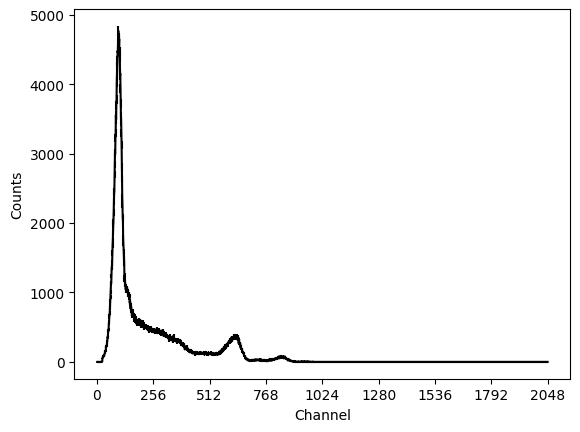

In [2]:
# load data entire gamma spectrum
channel_gam, counts_gam = np.loadtxt('Data/PCA3-ADC_gamma_spec_all.RPT', unpack=True)
plt.errorbar(channel_gam, counts_gam, yerr=np.sqrt(counts_gam), xerr=1, c='black')
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.xticks([0, 256, 512, 768, 1024, 1280, 1536, 1792, 2048])
#plt.grid(True)
#plt.savefig('FitResults/A1_gamma_all.pdf', bbox_inches='tight')
plt.show()

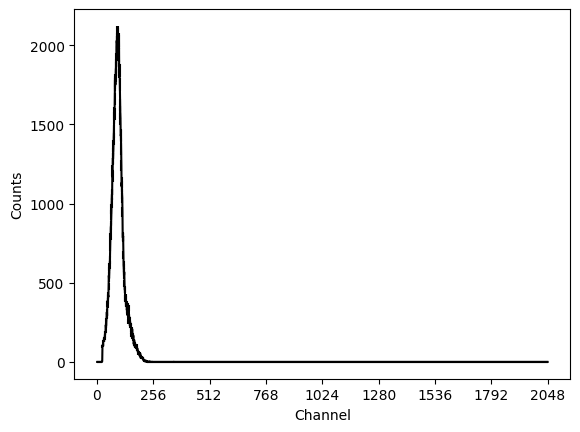

In [3]:
# load data selected gamma spectrum
channel_gam, counts_gam = np.loadtxt('Data/PCA3-ADC_gamma_selected.RPT', unpack=True)
plt.errorbar(channel_gam, counts_gam, yerr=np.sqrt(counts_gam), xerr=1, c='black')
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.xticks([0, 256, 512, 768, 1024, 1280, 1536, 1792, 2048])
#plt.grid(True)
#plt.savefig('FitResults/A1_gamma_selected.pdf', bbox_inches='tight')
plt.show()

# Velocity Calibration

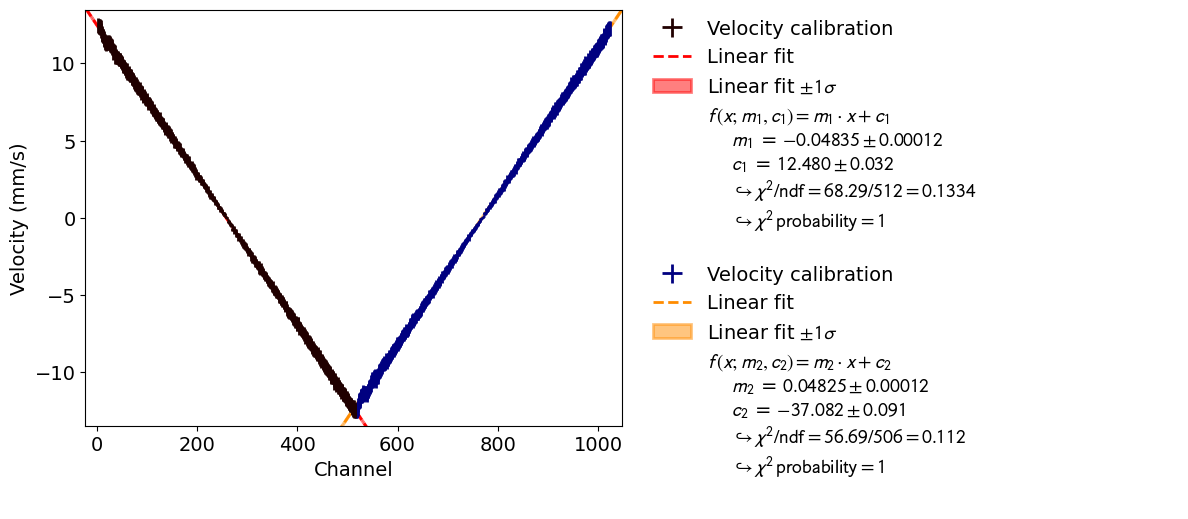

In [4]:
# load data
channel, counts = np.loadtxt('Data/PCA3-MCS_velocity.RPT', unpack=True)
#plt.scatter(channel[2:], counts[2:], c='black')


# determine knicks
knick_max = np.mean(channel[counts==np.max(counts[2:])])
knick_min1 = np.mean(channel[(counts==0) & (channel<knick_max)])
knick_min2 = np.mean(channel[(counts==0) & (channel>knick_max)])
#print(knick_min1, knick_max)

# get velocity from counts
BZ = counts[1] * 10e-6 # micro s
lam = 650e-9 #m
v = lam / 2 * counts / BZ * 1000 #mm/s

# Define the model function for the fit
def lin_fit(x, m, c):
    return m * x + c

# set data 1
y1 = np.array([])
x1 = channel[(channel>2) & (channel<=knick_max)]-0.5
y1 = np.append(y1, v[(channel>2) & (channel<=knick_min1)])
y1 = np.append(y1, -v[(channel>knick_min1) & (channel<=knick_max)])
xerr1 = 1
yerr1 = lam / 2 * np.sqrt(np.abs(counts[(channel>2) & (channel<=knick_max)])) / BZ * 1000 #mm/s

# Define the fit1
fit1 = XYFit(xy_data = [x1, y1], model_function = lin_fit)
fit1.add_error(axis = 'y', err_val = yerr1)
fit1.add_error(axis = 'x', err_val = xerr1)

# Optional1: Assign LaTeX expressions to the function and its variables.
fit1.assign_parameter_latex_names(m='m_1', x='x',c="c_1")
fit1.assign_model_function_latex_expression("{m} \cdot x+{c}")
fit1.assign_model_function_latex_name("f\,")
fit1.model_label = "Linear fit"
fit1.data_container.label = 'Velocity calibration'
fit1.data_container.axis_labels = ['Channel', 'Velocity (mm/s)']
 
fit1.do_fit()


# set data 2
y2 = np.array([])
x2 = channel[channel>knick_max]-0.5
y2 = np.append(y2, -v[(channel>knick_max) & (channel<=knick_min2)])
y2 = np.append(y2, v[channel>knick_min2])
xerr2 = 1
yerr2 = lam / 2 * np.sqrt(np.abs(counts[(channel>knick_max)])) / BZ * 1000 #mm/s

# Define the fit 2
fit2 = XYFit(xy_data = [x2, y2], model_function = lin_fit)
fit2.add_error(axis = 'y', err_val = yerr2)
fit2.add_error(axis = 'x', err_val = xerr2)


# Optional: Assign LaTeX expressions to the function and its variables.
fit2.assign_parameter_latex_names(m='m_2', x='x',c="c_2")
fit2.assign_model_function_latex_expression("{m} \cdot x+{c}")
fit2.assign_model_function_latex_name("f\,")
fit2.model_label = "Linear fit"
fit2.data_container.label = 'Velocity calibration'
fit2.data_container.axis_labels = ['Channel', 'Velocity (mm/s)']

fit2.do_fit()



# Finaly plot the fit
plot = Plot([fit1, fit2])
plot.y_range = (-np.max(v[2:])-1, np.max(v[2:])+1)
plot.customize('model_line', 'color', [(0, 'red'), (1, 'darkorange')])
plot.customize('model_error_band', 'color', [(0, 'red'), (1, 'darkorange')])
plot.customize('data', 'marker', [(0, '.'), (1,'.')])
plot.customize('data', 'markersize', [(0, 2), (1, 2)])
plot.plot()

# and show everything
#plt.savefig("FitResults/VelocityCalibration.pdf", bbox_inches='tight')
plt.show()


In [5]:
# get fit parameters
m1, c1 = unumpy.uarray(fit1.parameter_values, fit1.parameter_errors)
m2, c2 = unumpy.uarray(fit2.parameter_values, fit2.parameter_errors)


# function velocity
def velocity(channel, knick, m1, c1, m2, c2):
    channel_n = unumpy.uarray(channel, np.ones(len(channel)))
    v = np.array([])
    verr = np.array([])
    v1 = m1 * channel_n[:int(knick)] + c1
    v2 = m2 * channel_n[int(knick):] + c2
    v = np.append(v, unumpy.nominal_values(v1))
    verr = np.append(verr, unumpy.std_devs(v1))
    v = np.append(v, unumpy.nominal_values(v2))
    verr = np.append(verr, unumpy.std_devs(v2))
    return unumpy.uarray(v, verr)

v = velocity(channel[2:], knick_max, m1, c1, m2, c2)


# Lorentzian peak Fit function

In [6]:
# Define Lorentzian fit function
def lorentzian(ch, ch0, gamma, A):
    """
    Einzelner Lorentzian Peak.

    Args:
        ch: Kanalnummer bzw. Geschwindigkeit
        ch0: Mittelpunkt des Peaks
        gamma: full width at half maximum
        A: Skalierungsfaktor; positiv, wenn Peak nach unten zeigt

    Returns:
        Den Peak natürlich...
    """
    return -A / (1 + ((ch - ch0) / (gamma/2) )**2)

# Individuelle Modelle, weil ich zu faul war, mir was Besseres zu überlegen.
# Summe aus mehreren Peaks plus konstanter Untergrund f

def model_Fe(ch, f, p1, g1, A1, p2, g2, A2, p3, g3, A3, p4, g4, A4, p5, g5, A5, p6, g6, A6):
    return lorentzian(ch, p1, g1, A1) + lorentzian(ch, p2, g2, A2) + lorentzian(ch, p3, g3, A3) + lorentzian(ch, p4, g4, A4) + lorentzian(ch, p5, g5, A5) + lorentzian(ch, p6, g6, A6) + f

def model_FePO4(ch, f, p1, g1, A1, p2, g2, A2):
    return lorentzian(ch, p1, g1, A1) + lorentzian(ch, p2, g2, A2) + f

def model_FeSO4(ch, f, p1, g1, A1, p2, g2, A2):
    return lorentzian(ch, p1, g1, A1) + lorentzian(ch, p2, g2, A2) + f

def model_vacromium(ch, f, p1, g1, A1):
    return lorentzian(ch, p1, g1, A1) + f

# Mößbauer spectrum vacromium

[4691. 4729. 4733. ... 5812. 5814. 5817.] [[762]]


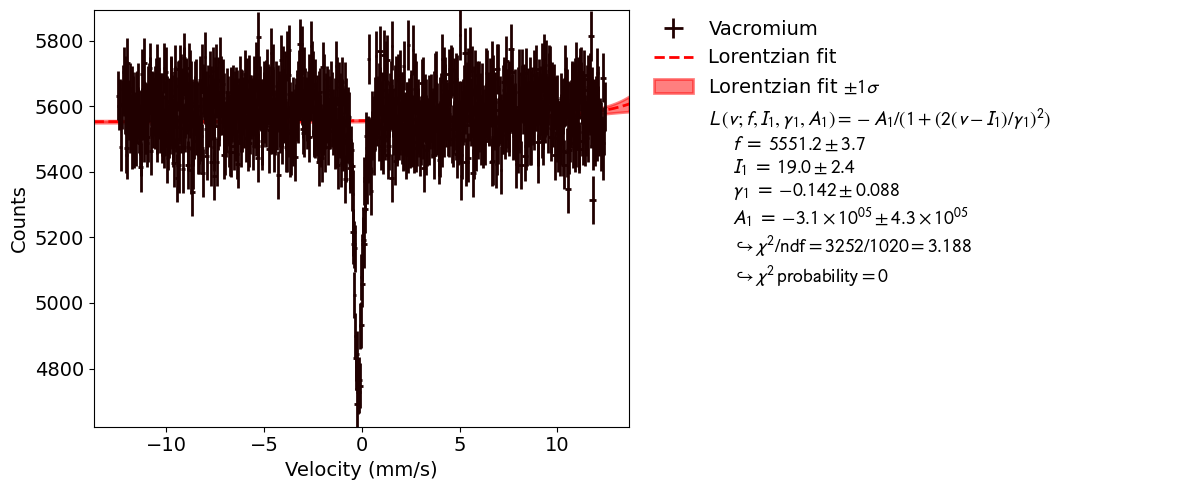

In [7]:
# load data vacromium
channel_va, counts_va = np.loadtxt('Data/PCA3-MCS_Vacromium.RPT', unpack=True)

# counts into velocities
v_va = unumpy.nominal_values(velocity(channel_va, knick_max, m1, c1, m2, c2))
v_va_err = unumpy.std_devs(velocity(channel_va, knick_max, m1, c1, m2, c2))

p = np.sort(counts_va)
peak = np.argwhere(counts_va == p[0])
print(p, peak)

# Create XYContainer
data_va = XYContainer(v_va, counts_va) 
data_va.add_error(axis='x', err_val=v_va_err) 
data_va.add_error(axis='y', err_val=np.sqrt(counts_va)) 


# Create Fit object
fit_va = Fit(data_va, model_vacromium)#, initial_parameters)

# Optional: Assign LaTeX expressions to the function and its variables.
fit_va.assign_parameter_latex_names(ch="v", f="f",p1="I_1",g1=r"\gamma_1",A1="A_1")
fit_va.assign_model_function_latex_expression(r"-{A1} / (1+(2(v-{p1})/{g1})^2)") #-A / (1 + ((ch - ch0) / (gamma/2) )**2)
fit_va.assign_model_function_latex_name("L\,")
fit_va.model_label = "Lorentzian fit"
fit_va.data_container.label = 'Vacromium'
fit_va.data_container.axis_labels = ['Velocity (mm/s)', 'Counts']

# Perform the fit
fit_va.do_fit()


# Create a plot of the data and the fit
plot = Plot(fit_va)

plot.customize('data', 'marker',  '.')
plot.customize('data', 'markersize', 1)
plot.customize('model_line', 'color', 'red')
plot.customize('model_error_band', 'color', 'red')
plot.customize('data', 'marker', '.')
plot.customize('data', 'markersize', 2)
plot.plot()
plot.show()

#print(f"Fit results:")
#print(f"{'Peak':<5} {'Position':<20} {'Breite':<20}")
#for i in range(ps):
    #print(f"{i+1:<5} {popt[3*i+1]:<7.3f} +/- {perr[3*i+1]:<8.3f} {popt[3*i+2]:<7.3f} +/- {perr[3*i+2]:<8.3f}")

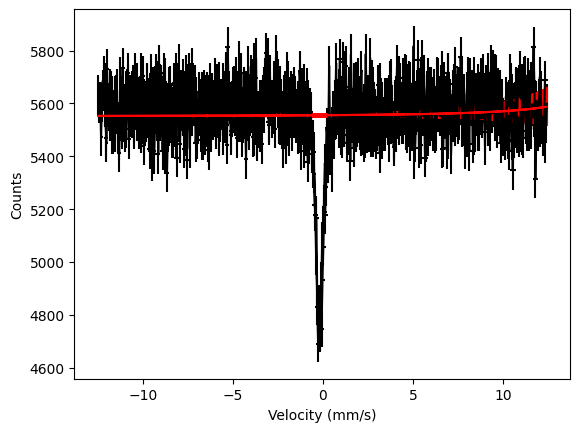

In [8]:
f, p1, g1, A1 = unumpy.uarray(fit_va.parameter_values, fit_va.parameter_errors)

#print(g1)


plt.errorbar(v_va, counts_va, yerr=np.sqrt(counts_va), xerr=v_va_err, c='black', markersize=1)#, alpha=0.4)
plt.errorbar(v_va, unumpy.nominal_values(lorentzian(v_va, p1, g1, A1) + f), yerr=unumpy.std_devs(lorentzian(v_va, p1, g1, A1) + f), xerr=v_va_err, c='red', markersize=1)
plt.xlabel('Velocity (mm/s)')
plt.ylabel('Counts')
plt.show()


# Mößbauer spectrum Iron

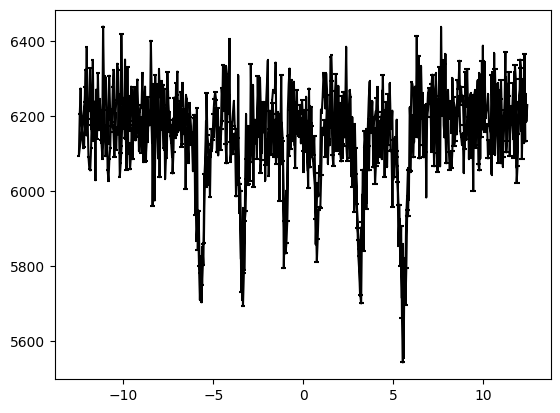

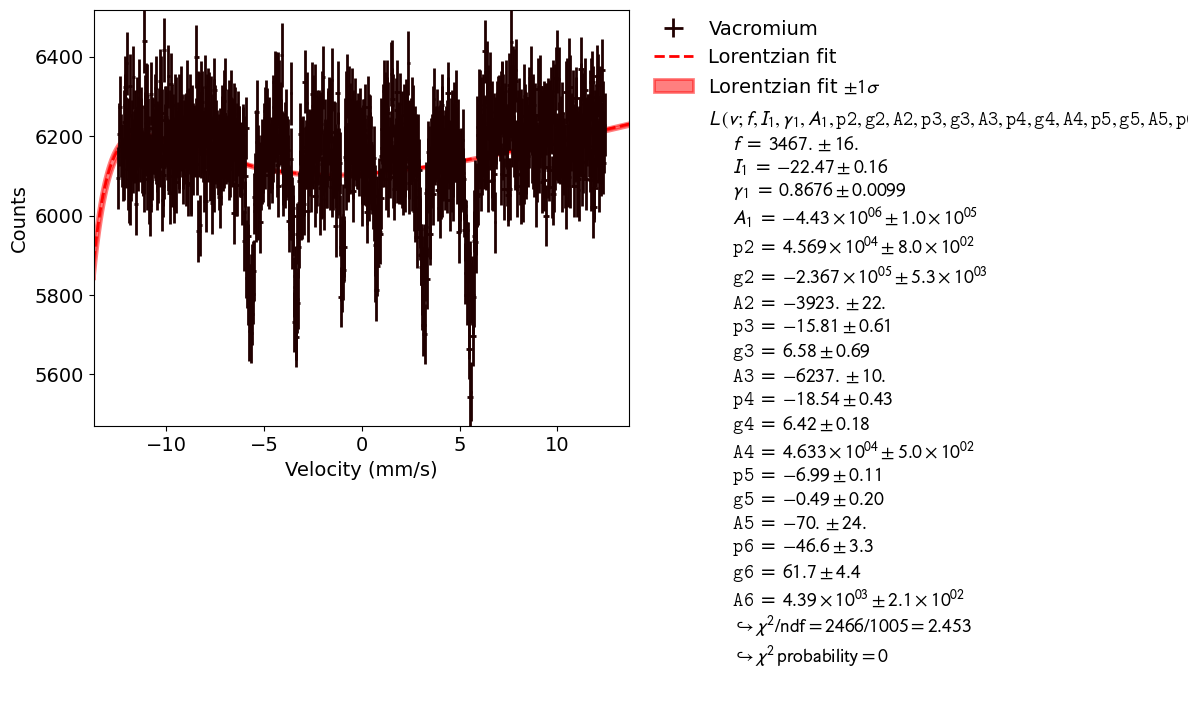

In [9]:
# load data iron
channel_fe, counts_fe = np.loadtxt('Data/PCA3-MCS_Iron.RPT', unpack=True)

# counts into velocities
v_fe = unumpy.nominal_values(velocity(channel_fe, knick_max, m1, c1, m2, c2))
v_fe_err = unumpy.std_devs(velocity(channel_fe, knick_max, m1, c1, m2, c2))


plt.errorbar(v_fe, counts_fe, yerr=v_fe_err, xerr=v_fe_err, c='black', markersize=1)


# Create XYContainer
data_fe = XYContainer(v_fe, counts_fe) 
data_fe.add_error(axis='x', err_val=v_fe_err) 
data_fe.add_error(axis='y', err_val=np.sqrt(counts_fe)) 


# Create Fit object
fit_fe = Fit(data_fe, model_Fe)#, initial_parameters)

# Optional: Assign LaTeX expressions to the function and its variables.
fit_fe.assign_parameter_latex_names(ch="v", f="f",p1="I_1",g1=r"\gamma_1",A1="A_1")
fit_fe.assign_model_function_latex_expression(r"-{A1} / (1+(2(v-{p1})/{g1})^2)") #-A / (1 + ((ch - ch0) / (gamma/2) )**2)
fit_fe.assign_model_function_latex_name("L\,")
fit_fe.model_label = "Lorentzian fit"
fit_fe.data_container.label = 'Vacromium'
fit_fe.data_container.axis_labels = ['Velocity (mm/s)', 'Counts']

# Perform the fit
fit_fe.do_fit()


# Create a plot of the data and the fit
plot = Plot(fit_fe)

plot.customize('data', 'marker',  '.')
plot.customize('data', 'markersize', 1)
plot.customize('model_line', 'color', 'red')
plot.customize('model_error_band', 'color', 'red')
plot.customize('data', 'marker', '.')
plot.customize('data', 'markersize', 2)
plot.plot()
plot.show()
